In [417]:
from symred.projection import S3_projection, QubitTapering, CS_VQE_LW
from symred.symplectic import *
from symred.utils import exact_gs_energy
from symred.utils import gf2_gaus_elim, gf2_basis_for_gf2_rref
from symred.chem import FermionicHamilt, FermioniCC, PySCFDriver, geometry_from_pubchem
from openfermion import get_fermion_operator, jordan_wigner, hermitian_conjugated, QubitOperator
from matplotlib import pyplot as plt
from functools import reduce
import json

In [418]:
with open('data/molecule_data.json', 'r') as jfile:
    molecule_geometries = json.load(jfile)
#with open('data/score_data.json', 'r') as infile:
#    scoring_data = json.load(infile)
print(molecule_geometries.keys())

dict_keys(['H2_3-21G_SINGLET', 'H6_STO-3G_SINGLET', 'H2_6-31G_SINGLET', 'H2_6-311G_SINGLET', 'H3+_STO-3G_SINGLET', 'H3+_3-21G_SINGLET', 'HeH+_3-21G_SINGLET', 'HeH+_6-311G_SINGLET', 'H2O_STO-3G_SINGLET', 'BeH+_STO-3G_SINGLET', 'LiH_STO-3G_SINGLET', 'CH+_STO-3G_SINGLET', 'HF_STO-3G_SINGLET', 'B+_STO-3G_SINGLET', 'B_STO-3G_DOUBLET', 'N_STO-3G_QUARTET', 'OH-_STO-3G_SINGLET', 'O_STO-3G_TRIPLET', 'CH2_STO-3G_TRIPLET', 'BeH2_STO-3G_SINGLET', 'Be_STO-3G_SINGLET', 'C_STO-3G_TRIPLET', 'NH_STO-3G_SINGLET', 'Ne_STO-3G_SINGLET', 'F_STO-3G_DOUBLET', 'Li_STO-3G_DOUBLET', 'BH_STO-3G_SINGLET', 'NeH+_STO-3G_SINGLET', 'NH2-_STO-3G_SINGLET', 'BH3_STO-3G_SINGLET', 'BH2+_STO-3G_SINGLET', 'HCl_STO-3G_SINGLET', 'H4_STO-3G_SINGLET', 'NH3_STO-3G_SINGLET', 'F2_STO-3G_SINGLET', 'HCN_STO-3G_SINGLET', 'CH4_STO-3G_SINGLET', 'CH3NHCH3_STO-3G_SINGLET', 'CH3CH2NH2_STO-3G_SINGLET', 'CH3CH2OH_STO-3G_SINGLET', 'CH3OH_STO-3G_SINGLET', 'C2H6_STO-3G_SINGLET', 'CH3CN_STO-3G_SINGLET', 'CH3CHO_STO-3G_SINGLET', 'CH3CHOHCH3_STO-3

In [481]:
# Set molecule parameters
speciesname = 'CH4_STO-3G_SINGLET'
#print(speciesname in scoring_data)
mol_data = molecule_geometries[speciesname]
if 'name' in mol_data:
    print(mol_data['name'])
    
atoms = mol_data['atoms']
coords = mol_data['coords']
basis = mol_data['basis']
multiplicity = mol_data['multiplicity'] #'6-31g' #'cc-pVDZ' #
charge = mol_data['charge']
geometry = list(zip(atoms, coords))
#geometry = geometry_from_pubchem('N2')

xyz_file = str(len(atoms))+'\n '

for atom, coords in geometry:
    xyz_file += '\n'+atom+'\t'
    xyz_file += '\t'.join(list(map(str, coords)))
#xyz_file = '4\n \nH\t0\t0\t0\nH\t2.45366053071732\t0\t0\nH\t2.45366053071732\t2.45366053071732\t0\nH\t0\t2.45366053071732\t0\n'
print('Molecule geometry:')
print(xyz_file[4:])

methane
Molecule geometry:
C	0.0	0.0	0.0
H	0.638353	0.638353	0.638353
H	-0.638353	-0.638353	0.638353
H	-0.638353	0.638353	-0.638353
H	0.638353	-0.638353	-0.638353


In [482]:
convergence = 1e-6; max_hf_cycles=100_000; ram = 8_000
run_mp2  = True; run_cisd = False; run_ccsd = True; run_fci  = True#False

pyscf_obj = PySCFDriver(xyz_file,
                        basis,
                        #convergence=convergence,
                        charge=charge,
                        #max_ram_memory=ram,
                        #max_hf_cycles=max_hf_cycles,                   
                        run_mp2=run_mp2,
                        run_cisd=run_cisd,
                        run_ccsd=run_ccsd,
                        run_fci=run_fci)

pyscf_obj.run_pyscf()

print('HF converged?  ', pyscf_obj.pyscf_hf.converged)
print('CCSD converged?', pyscf_obj.pyscf_ccsd.converged)
if run_fci:
    print('FCI converged? ', pyscf_obj.pyscf_fci.converged)
    fci_energy = pyscf_obj.pyscf_fci.e_tot
else:
    fci_energy = None
    
hf_energy = pyscf_obj.pyscf_hf.e_tot
mp2_energy = pyscf_obj.pyscf_mp2.e_tot
ccsd_energy = pyscf_obj.pyscf_ccsd.e_tot

print()
print(f'HF energy: {hf_energy}')
print(f'MP2 energy: {mp2_energy}')
print(f'CCSD energy: {ccsd_energy}')
print(f'FCI energy: {fci_energy}')

HF converged?   True
CCSD converged? True
FCI converged?  True

HF energy: -39.725187257764716
MP2 energy: -39.783397793109344
CCSD energy: -39.806729896423676
FCI energy: -39.80698697524694


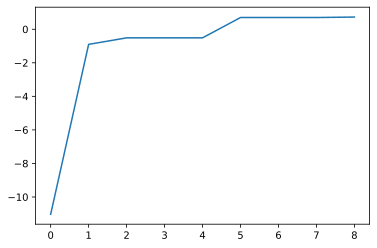

In [483]:
plt.plot(pyscf_obj.pyscf_hf.mo_energy)

In [484]:
from symred.utils import QubitOperator_to_dict

# build fermionic Hamiltonian
H_fermion = FermionicHamilt(pyscf_obj.pyscf_hf)
T_fermion = FermioniCC(pyscf_obj.pyscf_ccsd)
H_fermion.build_operator()
T_fermion.build_operator()

n_qubits = H_fermion.n_qubits
print('Number of qubits:', n_qubits)

H = get_fermion_operator(H_fermion.fermionic_molecular_hamiltonian)
T = T_fermion.fermionic_cc_operator
#T -= hermitian_conjugated(T)

# map to QubitOperator via Jordan-Wigner
H_jw = jordan_wigner(H)
T_jw = jordan_wigner(T)

# convert to PauliwordOp
H_q = PauliwordOp(QubitOperator_to_dict(H_jw, n_qubits))
T_q = PauliwordOp(QubitOperator_to_dict(T_jw, n_qubits))
T_q.coeff_vec = T_q.coeff_vec.imag

Number of qubits: 18


In [485]:
taper_hamiltonian = QubitTapering(H_q)

print(f'We are able to taper {taper_hamiltonian.n_taper} qubits from the Hamiltonian.\n')
print('The symmetry generators are\n')
print(taper_hamiltonian.symmetry_generators)
print('\nand may be rotated via a sequence of Clifford pi/2 rotations\n')
print(taper_hamiltonian.stabilizers.stabilizer_rotations)
print('\nonto the single-qubit Pauli operators\n')
print(taper_hamiltonian.stabilizers.rotate_onto_single_qubit_paulis())

We are able to taper 2 qubits from the Hamiltonian.

The symmetry generators are

1.0000000000+0.0000000000j ZIZIZIZIZIZIZIZIZI +
1.0000000000+0.0000000000j IZIZIZIZIZIZIZIZIZ

and may be rotated via a sequence of Clifford pi/2 rotations

[('YIZIZIZIZIZIZIZIZI', None), ('IYIZIZIZIZIZIZIZIZ', None)]

onto the single-qubit Pauli operators

-1.0000000000+0.0000000000j XIIIIIIIIIIIIIIIII +
-1.0000000000+0.0000000000j IXIIIIIIIIIIIIIIII


In [486]:
hf_array = H_fermion.hf_comp_basis_state
taper_hamiltonian.stabilizers.update_sector(hf_array)
print(f'The symmetry sector corresponding with the single reference {hf_array} is {taper_hamiltonian.stabilizers.coeff_vec}')

The symmetry sector corresponding with the single reference [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0] is [-1 -1]


In [487]:
ham_tap = taper_hamiltonian.taper_it(ref_state=hf_array)
#sor_tap = taper_hamiltonian.taper_it(aux_operator=sor_ham, ref_state=hf_array)
#sor_tap.coeff_vec/=np.linalg.norm(sor_tap.coeff_vec)
ucc_tap = taper_hamiltonian.taper_it(aux_operator=T_q, ref_state=hf_array)
n_taper = taper_hamiltonian.n_taper
tapered_qubits   = taper_hamiltonian.stab_qubit_indices
untapered_qubits = taper_hamiltonian.free_qubit_indices
hf_tapered = taper_hamiltonian.tapered_ref_state

print(f'The tapered Hartree-Fock state is', QuantumState([hf_tapered]))

The tapered Hartree-Fock state is  1.0000000000 |1111111100000000>


In [488]:
cs_vqe_lw = CS_VQE_LW(ham_tap, hf_tapered, basis_weighting_operator=ucc_tap)
cs_vqe_lw_2 = CS_VQE_LW(ham_tap, hf_tapered)

In [506]:
HL_gap = np.where(hf_tapered==0)[0][0]
def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

bias=1
HL_bias = gaussian(np.arange(0,ucc_tap.n_qubits), HL_gap-0.5, bias)
HL_biased_coeffs = np.sum(ham_tap.X_block*HL_bias, axis=1)*ham_tap.coeff_vec
hlg_op = PauliwordOp(ham_tap.symp_matrix, HL_biased_coeffs)

ucc_sort = ucc_tap.sort(key='magnitude')
ham_sort = ham_tap.sort(key='magnitude')
hlg_sort = hlg_op.sort(key='magnitude')

def stabilizers_by_term_significance(n_terms, weighting_operator):
    preserve = weighting_operator.sort(key='magnitude')[:n_terms]# + cs_vqe.clique_operator[1]
    ZX_symp = np.hstack([preserve.Z_block, preserve.X_block])
    reduced = gf2_gaus_elim(ZX_symp)
    kernel  = gf2_basis_for_gf2_rref(reduced)
    stabilizers = StabilizerOp(kernel, np.ones(kernel.shape[0]))
    mask_diag = np.where(~np.any(stabilizers.X_block, axis=1))[0]
    return StabilizerOp(stabilizers.symp_matrix[mask_diag], stabilizers.coeff_vec[mask_diag])

def find_stabilizers(n_sim_qubits, weighting_operator=hlg_sort, region=[0,ucc_sort.n_terms]):
    assert(n_sim_qubits < ham_tap.n_qubits), 'Number of qubits to simulate exceeds those in the operator'
    assert(region[1]-region[0]>1), 'Search region collapsed without identifying any stabilizers'
    
    n_terms = sum(region)//2
    stabilizers = stabilizers_by_term_significance(n_terms, weighting_operator)
    current_n_qubits = ham_tap.n_qubits - stabilizers.n_terms
    sign = np.sign(current_n_qubits - n_sim_qubits)
    
    if sign==0:
        # i.e. n_sim_qubits == current_n_qubits
        return stabilizers
    elif sign==+1:
        # i.e. n_sim_qubits < current_n_qubits
        region[1] = n_terms
    else:
        region[0] = n_terms
    return find_stabilizers(n_sim_qubits, weighting_operator, region)

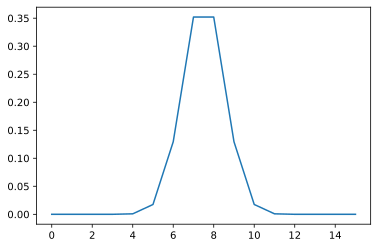

In [507]:
plt.plot(HL_bias)

In [508]:
ref_energy = fci_energy
max_sim_q = 10

scores = []
energy = []

for i in range(1, ham_tap.n_qubits):
    try:
        stabilizers =  find_stabilizers(n_sim_qubits=i, region=[0,ucc_sort.n_terms])
        stab_score = cs_vqe_lw.basis_score(stabilizers)
        scores.append(stab_score)
        print('Basis score (min:0, max:1):', stab_score)
        if i<=max_sim_q:
            ham_cs = cs_vqe_lw.project_onto_subspace(stabilizers)
            print(f'Number of qubits in contextual subspace: {ham_cs.n_qubits}/{ham_tap.n_qubits}')
            matrix = ham_cs.to_sparse_matrix
            e = exact_gs_energy(matrix)[0]
            print('Error from CCSD:', e-ref_energy)
            energy.append(e)
    except:
        print(i, 'did not work')

Basis score (min:0, max:1): 0.003781586446521143
Number of qubits in contextual subspace: 1/16
Error from CCSD: 0.08179971748214143
Basis score (min:0, max:1): 0.21896081301661927
Number of qubits in contextual subspace: 2/16
Error from CCSD: 0.07791382844042971
Basis score (min:0, max:1): 0.24551292636200103
Number of qubits in contextual subspace: 3/16
Error from CCSD: 0.0770720517885124
Basis score (min:0, max:1): 0.26471001059222593
Number of qubits in contextual subspace: 4/16
Error from CCSD: 0.07631658056023838
Basis score (min:0, max:1): 0.28248012465910505
Number of qubits in contextual subspace: 5/16
Error from CCSD: 0.07555723936016534
Basis score (min:0, max:1): 0.2948806833922837
Number of qubits in contextual subspace: 6/16
Error from CCSD: 0.07479820043487706
Basis score (min:0, max:1): 0.3092791161831291
Number of qubits in contextual subspace: 7/16
Error from CCSD: 0.07420791567432872
Basis score (min:0, max:1): 0.36322452475068295
Number of qubits in contextual subspa

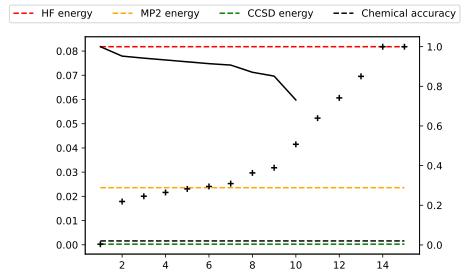

In [509]:
from matplotlib import pyplot as plt
#plt.style.use('ggplot')

fig,energy_axis = plt.subplots()
X=np.arange(1, ham_tap.n_qubits)

Y_energy=np.array(energy)-ref_energy
energy_axis.plot(X[:max_sim_q], Y_energy, color='black')
energy_axis.hlines(hf_energy-ref_energy, 1, X[-1], ls='--', color='red', label='HF energy')
energy_axis.hlines(mp2_energy-ref_energy, 1, X[-1], ls='--', color='orange', label='MP2 energy')
energy_axis.hlines(ccsd_energy-ref_energy, 1, X[-1], ls='--', color='green', label='CCSD energy')
energy_axis.hlines(0.0016, 1, X[-1], ls='--', color='black', label='Chemical accuracy')

#energy_axis.set_ylim(1e-15, 1e-0) 
#energy_axis.set_yscale('log')

score_axis = energy_axis.twinx()
Y_scores=np.array(scores)
score_axis.scatter(X, Y_scores, color='black', marker='+')

#energy_axis.set_xticks(X)

fig.legend(ncol=4)
plt.show()

In [42]:
#with open('data/score_data.json', 'r') as infile:
#    scoring_data = json.load(infile)
    
#scoring_data

In [43]:
#speciesname = 'H2O_6-31g_SINGLET'

#scoring_data[speciesname] = {
#    'n_qubits_pre_taper': H_q.n_qubits, 
#    'n_qubits_post_taper': ham_tap.n_qubits,
#    'hf_energy': hf_energy,
#    'mp2_energy': mp2_energy,
#    'ccsd_energy': ccsd_energy,
#    'fci_energy': fci_energy,
#    'cs_vqe_energies': energy,
#    'stabilizer_score': scores
#}

#scoring_data

In [44]:
#with open('data/score_data.json', 'w') as outfile:
#    json.dump(scoring_data, outfile)

In [17]:
from scipy.special import comb

def random_stabs(n_stabs):
    Z_block = np.random.randint(0,2,(n_stabs, ham_tap.n_qubits))
    S = StabilizerOp(np.hstack([np.zeros_like(Z_block), Z_block]), np.ones(n_stabs))
    return S

def score_vs_energy(n_stabs):
    S = random_stabs(n_stabs)
    ucc_stab_score = cs_vqe_lw.basis_score(S)
    ham_stab_score = cs_vqe_lw_2.basis_score(S)
    ham_cs = cs_vqe_lw.project_onto_subspace(S)
    matrix = ham_cs.to_sparse_matrix
    e = exact_gs_energy(matrix)[0]
    return ham_stab_score, ucc_stab_score, e

data={}

for n_stabs in range(1, ham_tap.n_qubits):
    print(f'Randomizing {n_stabs} stabilizer(s)')
    count=0
    results = []
    while count<=2**ham_tap.n_qubits:
        try:
            results.append(score_vs_energy(n_stabs))
            count+=1
        except:
            pass
    data[ham_tap.n_qubits-n_stabs] = results

Randomizing 1 stabilizer(s)
Randomizing 2 stabilizer(s)
Randomizing 3 stabilizer(s)
Randomizing 4 stabilizer(s)
Randomizing 5 stabilizer(s)
Randomizing 6 stabilizer(s)
Randomizing 7 stabilizer(s)
Randomizing 8 stabilizer(s)


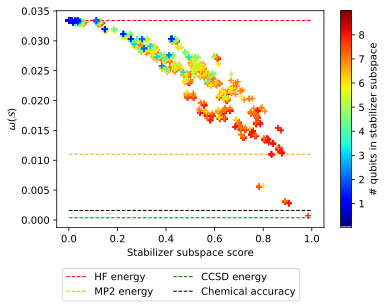

In [23]:
from matplotlib.pyplot import Normalize

fig,axis = plt.subplots()

increments = []

for n_qubits,results in data.items():
    ratio = n_qubits/ham_tap.n_qubits
    increments.append(ratio)
    c = plt.cm.jet(ratio)
    X_ham, X_ucc, Y = zip(*results)
    X = np.array(X_ucc)
    Y = np.array(Y) - fci_energy
    axis.scatter(
        X, 
        Y, 
        marker='+', 
        color=c, 
        zorder=1,#n_qubits,
        alpha=0.9)
    
keys = list(data.keys())
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=Normalize(), cmap='jet'), 
                     ax=axis, label='# qubits in stabilizer subspace', ticks=increments)#, fraction=0.78)
cbar.ax.set_yticklabels(keys)

axis.set_xlabel('Stabilizer subspace score')
axis.set_ylabel('$\omega(\mathcal{S})$')

axis.hlines(hf_energy-fci_energy, 0, 1, ls='--', lw=1, color='red', zorder=0, label='HF energy')
axis.hlines(mp2_energy-fci_energy, 0, 1, ls='--', lw=1, color='orange', zorder=0, label='MP2 energy')
axis.hlines(ccsd_energy-fci_energy, 0, 1, ls='--', lw=1, color='green', zorder=0, label='CCSD energy')
axis.hlines(0.0016, 0, 1, ls='--', lw=1, color='black', zorder=0, label='Chemical accuracy')

fig.legend(ncol=2, bbox_to_anchor=(0.7,0))

In [31]:
#with open('data/score_vs_energy.json', 'r') as infile:
#    score_vs_energy = json.load(infile)
#    
#score_vs_energy.keys()

In [32]:
#score_vs_energy[speciesname] = {
#    'n_qubits_pre_taper': H_q.n_qubits, 
#    'n_qubits_post_taper': ham_tap.n_qubits,
#    'hf_energy': hf_energy,
#    'mp2_energy': mp2_energy,
#    'ccsd_energy': ccsd_energy,
#    'fci_energy': fci_energy,
#    'ham_score_ucc_score_cs_energy':data
#}
#score_vs_energy

In [33]:
#with open('data/score_vs_energy.json', 'w') as outfile:
#    json.dump(score_vs_energy, outfile)

In [33]:
hf_tapered

array([1, 1, 1, 0, 0, 0, 0, 0, 0])

In [58]:
def region_about_HL_gap(degree):
    HL_gap = np.where(hf_array==0)[0][0]
    above, below = HL_gap+degree, HL_gap-degree
    if above>hf_array.shape:
        above=hf_array.shape
    return np.arange(below, above)

def nontrivial_HL_action(degree):
    region = region_about_HL_gap(degree)
    complement = np.array([i for i in np.arange(T_q.n_qubits) if i not in region])
    mask_nontrivial_strict = np.where(~np.any(T_q.X_block[:,complement], axis=1))
    mask_nontrivial_relaxed = np.where(np.any(T_q.X_block[:,region], axis=1))
    weighting = PauliwordOp(T_q.symp_matrix[mask_nontrivial_strict], T_q.coeff_vec[mask_nontrivial_strict]).sort(key='magnitude')
    weighting_tapered = taper_hamiltonian.taper_it(aux_operator=weighting, ref_state=hf_array)
    return weighting_tapered

def stab_by_HL(degree):
    weighting_tapered = nontrivial_HL_action(degree)
    stabs = stabilizers_by_term_significance(n_terms=weighting_tapered.n_terms, weighting_operator=weighting_tapered)
    return stabs

In [60]:
stabilizers = stab_by_HL(4)
#print(stabilizers)
print('Basis score (min:0, max:1):', cs_vqe_lw.basis_score(stabilizers))
ham_cs = cs_vqe_lw.project_onto_subspace(stabilizers)
print(f'Number of qubits in contextual subspace: {ham_cs.n_qubits}/{ham_tap.n_qubits}')

Basis score (min:0, max:1): 0.5980188533258916
Number of qubits in contextual subspace: 3/9


In [61]:
matrix = ham_cs.to_sparse_matrix
print(matrix.shape)
exact_gs_energy(matrix)[0] - fci_energy

(8, 8)


0.027416210891386683

In [62]:
print(ham_tap)

-8.4083001026+0.0000000000j IIIIIIIII +
0.0504799056+0.0000000000j XIIIIIIII +
0.0017481238+0.0000000000j IXIIIIIII +
0.0037195901-0.0000000000j XIXIIIIII +
-0.0039420048+0.0000000000j IIIXIIIII +
0.0038458789-0.0000000000j XIIXIIIII +
-0.0124803674+0.0000000000j XXIXIIIII +
0.0037664209-0.0000000000j IIXXIIIII +
-0.0039420048+0.0000000000j IIIIXIIII +
0.0038458789-0.0000000000j XIIIXIIII +
-0.0124803674+0.0000000000j XXIIXIIII +
0.0037664209-0.0000000000j IIXIXIIII +
0.0121246896+0.0000000000j IIIXXIIII +
0.0009000476+0.0000000000j XIIIIXXII +
-0.0127611780+0.0000000000j IIIXIXXII +
-0.0127611780+0.0000000000j IIIIXXXII +
-0.0017642852+0.0000000000j XIIIIIIXX +
-0.0041073507+0.0000000000j IIIXIIIXX +
-0.0041073507+0.0000000000j IIIIXIIXX +
0.0093689825+0.0000000000j ZIIIIIIII +
0.0327013633+0.0000000000j ZXIIIIIII +
0.0093689825+0.0000000000j IZIIIIIII +
0.1007706840+0.0000000000j ZZIIIIIII +
-0.0068813630+0.0000000000j YYIIIIIII +
0.0413005178-0.0000000000j YYXIIIIII +
0.0124803674-0

In [77]:
hf_tapered

array([1, 1, 1, 0, 0, 0, 0, 0, 0])

0.0955159732+0.0000000000j IXYIIYZXZ +
-0.0955159732+0.0000000000j IXYIIXZYZ +
0.0955159732+0.0000000000j IYXIIXZYZ +
-0.0955159732+0.0000000000j IYXIIYZXZ +
-0.0826010356+0.0000000000j XYYIIIIZZ +
-0.0826010356+0.0000000000j YXYIIIIII +
0.0826010356+0.0000000000j YYXIIIIII +
-0.0826010356+0.0000000000j XXXIIIIZZ +
0.0611918212+0.0000000000j IIXIIIIYY +
-0.0611918212+0.0000000000j IIYIIIIYX +
-0.0602197118+0.0000000000j IIYIIXXYI +
0.0602197118+0.0000000000j IIYIIYXXI +
-0.0602197118+0.0000000000j IIXIIYYXI +
0.0602197118+0.0000000000j IIXIIXYYI +
0.0589654479+0.0000000000j IIIIIXYYX +
-0.0589654479+0.0000000000j IIIIIXXYY +
-0.0589654479+0.0000000000j IIIIIYYXX +
0.0589654479+0.0000000000j IIIIIYXXY +
0.0557044175+0.0000000000j IYXIIYIII +
-0.0557044175+0.0000000000j IXYIIYIII +
-0.0557044175+0.0000000000j IXXIIXIZZ +
-0.0557044175+0.0000000000j IYYIIXIZZ +
-0.0479227112+0.0000000000j IYXIIIYIX +
-0.0479227112+0.0000000000j IXYIIIXIY +
0.0450768285+0.0000000000j IIXIIYYII +
-0.0450768

In [73]:
print(ucc_sort[:10])
stabilizers =  find_stabilizers(n_sim_qubits=6, region=[0,ucc_sort.n_terms], weighting_operator=ucc_sort)
stab_score = cs_vqe_lw.basis_score(stabilizers)
print(stabilizers)
print()
ham_cs = cs_vqe_lw.project_onto_subspace(stabilizers)
print(f'Number of qubits in contextual subspace: {ham_cs.n_qubits}/{ham_tap.n_qubits}')
matrix = ham_cs.to_sparse_matrix
e = exact_gs_energy(matrix)[0]
print('Error from FCI:', e-fci_energy)

0.0068212198+0.0000000000j XYIIXIIII +
0.0068212198+0.0000000000j YYIIYIIII +
0.0068212198+0.0000000000j YXIIXIIII +
-0.0068212198+0.0000000000j XXIIYIIII +
-0.0068212198+0.0000000000j XXIYIIIII +
0.0068212198+0.0000000000j XYIXIIIII +
0.0068212198+0.0000000000j YYIYIIIII +
0.0068212198+0.0000000000j YXIXIIIII +
-0.0048629295+0.0000000000j IIXIIIIXY +
0.0048629295+0.0000000000j IIYIIIIXX
1.0000000000+0.0000000000j ZIZZZIZZI +
1.0000000000+0.0000000000j IZZZZIZIZ +
1.0000000000+0.0000000000j IIIIIZZZZ

Number of qubits in contextual subspace: 6/9
Error from FCI: 0.0008523478181476918


In [30]:
print(ham_tap)

-8.4083001026+0.0000000000j IIIIIIIII +
0.0504799056+0.0000000000j XIIIIIIII +
0.0017481238+0.0000000000j IXIIIIIII +
0.0037195901-0.0000000000j XIXIIIIII +
-0.0039420048+0.0000000000j IIIXIIIII +
0.0038458789-0.0000000000j XIIXIIIII +
-0.0124803674+0.0000000000j XXIXIIIII +
0.0037664209-0.0000000000j IIXXIIIII +
-0.0039420048+0.0000000000j IIIIXIIII +
0.0038458789-0.0000000000j XIIIXIIII +
-0.0124803674+0.0000000000j XXIIXIIII +
0.0037664209-0.0000000000j IIXIXIIII +
0.0121246896+0.0000000000j IIIXXIIII +
0.0009000476+0.0000000000j XIIIIXXII +
-0.0127611780+0.0000000000j IIIXIXXII +
-0.0127611780+0.0000000000j IIIIXXXII +
-0.0017642852+0.0000000000j XIIIIIIXX +
-0.0041073507+0.0000000000j IIIXIIIXX +
-0.0041073507+0.0000000000j IIIIXIIXX +
0.0093689825+0.0000000000j ZIIIIIIII +
0.0327013633+0.0000000000j ZXIIIIIII +
0.0093689825+0.0000000000j IZIIIIIII +
0.1007706840+0.0000000000j ZZIIIIIII +
-0.0068813630+0.0000000000j YYIIIIIII +
0.0413005178-0.0000000000j YYXIIIIII +
0.0124803674-0

In [163]:
hf_array

array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0])